# Libs import

In [3]:
import json
api_token = {"username":"iobananaoi","key":"84cda1d87e243a61b9694f0ef68dc326"}


with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [92]:
import gc
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from kaggle.api.kaggle_api_extended import KaggleApi
from torchvision import transforms
from zipfile import ZipFile
from PIL import Image
from torchvision import models
from functools import reduce
from nltk.translate.bleu_score import corpus_bleu
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision.transforms.functional import to_pil_image

In [5]:
api = KaggleApi()
api.authenticate()

In [6]:
!kaggle datasets download -d aladdinpersson/flickr8kimagescaptions

100% 1.04G/1.04G [00:52<00:00, 21.1MB/s]
100% 1.04G/1.04G [00:52<00:00, 21.3MB/s]


In [7]:
with ZipFile("/content/flickr8kimagescaptions.zip") as f:
    f.extractall()

# Essential variables

In [8]:
# Image folder path
img_path="/content/flickr8k/images/"

# Path to file with captions
captions_path="/content/flickr8k/captions.txt"

# Encoder output dim
enc_dim = 2048

# Encoder num of pixels
num_pixels = 100

# Decoder output dim
dec_dim = 50

# Attention hidden dim
att_dim = 40

# Vocab size, including tokens <start>, <end>, <pad>, <unk>
vocab_size = 10272

# Max caption's length from dataset
max_cap_len = 37

# Embedding dim
emb_dim = 80

# Batch size
batch_size = 32

# Epochs
epochs = 10

# Learning rate for decoder
decoder_lr = 4e-4

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Data processing

### Wordmap creation

In [9]:
dataset = pd.read_csv(captions_path, sep=',')
captions = dataset["caption"]

words = set([w for caption in captions for w in caption[:-2].split(" ")])
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0

In [165]:
idx2word = {v: k for k, v in word_map.items()}

### Dataset

In [10]:
class Flickr8k(Dataset):
    def __init__(self, img_path=img_path, captions_path=captions_path, transform=None, train=True):
        self.df = pd.read_csv(captions_path, sep=",")
        self.df = self.df[:30000] if train else self.df[30000:]

        self.transform = transform
        self.img_path = img_path


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        # Read img and corresponding caption
        img_name, caption = self.df.iloc[idx]["image"], self.df.iloc[idx]["caption"][:-2]
        img = Image.open(self.img_path+img_name)

        # Make transformation of image
        if self.transform is not None:
            img = self.transform(img)

        # Encode captions
        caption = caption.split(" ")
        enc_cap = torch.tensor([word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in caption] + [
            word_map['<end>']] + [word_map['<pad>']] * (max_cap_len - len(caption)))

        # Find caption length
        c_len = len(caption) + 2

        return img, enc_cap, c_len

In [11]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

train_ds, test_ds = Flickr8k(train=True, transform=transform), Flickr8k(train=False, transform=transform)

### DataLoader

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, drop_last=True)

In [13]:
def make_grid(images, caps, nrows=3, ncols=3):
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 13))
    for i in range(ncols*nrows):
        row = i // ncols
        col = i % ncols
        img = images[i].cpu().squeeze().permute(1, 2, 0)

        ax[row, col].set_title(caps[i])
        ax[row, col].imshow(img)

    plt.show()

# Model architecture

In [102]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        resnet = models.resnet50(weights='DEFAULT')
        for p in resnet.parameters():
            p.requires_grad = False

        modules = list(resnet.children())[:-2] # Delete last 2 layers as long as we don't have classification problem
        self.resnet = nn.Sequential(*modules)
    
    def forward(self, x):
        x = self.resnet(x)
        x = x.permute(0, 2, 3, 1) # [batch_size, 10, 10, 2048]
        x = x.view(x.size(0), -1, x.size(-1)) # (batch_size, num_pixels (100), enc_dim (2048))

        return x 

In [103]:
class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim, att_dim):
        super(Attention, self).__init__()
    
        self.enc_att = nn.Linear(enc_dim, att_dim) # Attention to encoder output
        self.dec_att = nn.Linear(dec_dim, att_dim) # Attention to decoder output
        self.full_att = nn.Linear(att_dim, 1)  
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, enc_out, dec_hidden):
        att1 = self.enc_att(enc_out)

        att2 = self.dec_att(dec_hidden)  
        
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2) 
        alpha = self.softmax(att)  # (batch_size, num_pixels)

        att_weighted_encoding = (enc_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, enc_dim)

        return att_weighted_encoding, alpha

In [132]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.attention = Attention(enc_dim, dec_dim, att_dim)

        self.embedding = nn.Embedding(vocab_size, emb_dim)

        self.lstm = nn.LSTMCell(emb_dim + enc_dim, dec_dim)
        
        self.init_h = nn.Linear(enc_dim, dec_dim)  # hidden state of LSTMCell
        self.init_c = nn.Linear(enc_dim, dec_dim)  # cell state of LSTMCell
        self.f_beta = nn.Linear(dec_dim, enc_dim)  # sigmoid-activated gate

        self.dropout = nn.Dropout()

        self.sigmoid = nn.Sigmoid()

        self.fc = nn.Linear(dec_dim, vocab_size)  # linear layer to find scores over vocabulary

        self.init_weights()  # initialize some layers with the uniform distribution


    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)


    def init_hidden_state(self, enc_out):
        mean_enc_out = enc_out.mean(dim=1)
        h = self.init_h(mean_enc_out)  # (batch_size, dec_dim)
        c = self.init_c(mean_enc_out)

        return h, c


    def forward(self, enc_out, enc_captions, caption_lengths):

        # Sort input data by decreasing lengths
        caption_lengths, sort_ind = torch.sort(caption_lengths, descending=True)
        enc_out = enc_out[sort_ind]
        enc_captions = enc_captions[sort_ind]

        # Convert captions to embeddings 
        embeddings = self.embedding(enc_captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(enc_out)  # (batch_size, decoder_dim)

        # For decoding we don't use <end> token, cause after it was generated our decoding ends

        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors for word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)


        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths]) # N_t from the article, means that we take all the images, which cap_len is greater than current time_stamp

            attention_weighted_encoding, alpha = self.attention(enc_out[:batch_size_t], h[:batch_size_t])

            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            h, c = self.lstm(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)

            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)

            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, enc_captions, decode_lengths, alphas, sort_ind

# Training

In [133]:
def accuracy(scores, targets, k):
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()
    return correct_total.item() / len(correct)

In [134]:
def train(enc, dec, dec_optim, dataloader, criterion):
    dec.train()

    min_loss = 1000
    losses = []
    accuracies = []
    enc_state_dict = None
    dec_state_dict = None

    for epoch in range(1, epochs+1):
        print(f"======= Epoch: {epoch} =======")
        for i, (imgs, caps, caplens) in enumerate(dataloader):
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            encoded_imgs = enc(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = dec(encoded_imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

            # Evaluate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += 1. * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Back prop
            dec_optim.zero_grad()
            loss.backward()

            dec_optim.step()

            # Gradient clipping

            torch.nn.utils.clip_grad_norm_(dec.parameters(), 1)

            # Metrics
            losses.append(loss.item())
            top5 = accuracy(scores, targets, 5)
            accuracies.append(top5)

            if loss.item() < min_loss:
                min_loss = loss.item()
                enc_state_dict = enc.state_dict()
                dec_state_dict = dec.state_dict()

            
            if i % 100 == 0:
                print(f"Batch: {i} Loss: {loss.item()} Top-5 Accuracy {top5:.3f}")

    print(f"Models saved with minimal loss: {min_loss:.4f}")

    return enc_state_dict, dec_state_dict

In [135]:
enc = Encoder().to(device)
#dec_optim = torch.optim.Adam(enc.parameters(), lr=1e-4)

dec = Decoder().to(device)
dec_optim = torch.optim.Adam(dec.parameters(), lr=decoder_lr)

criterion = nn.CrossEntropyLoss().to(device)

In [136]:
enc, dec = train(enc, dec, dec_optim, train_dl, criterion)

======= Epoch: 1 =======
Batch: 0 Loss: 10.004826545715332 Top-5 Accuracy 0.000
Batch: 100 Loss: 7.48149299621582 Top-5 Accuracy 0.251
Batch: 200 Loss: 6.316845893859863 Top-5 Accuracy 0.312
Batch: 300 Loss: 6.333850383758545 Top-5 Accuracy 0.306
Batch: 400 Loss: 6.402807235717773 Top-5 Accuracy 0.327
Batch: 500 Loss: 6.170252323150635 Top-5 Accuracy 0.299
Batch: 600 Loss: 6.277156829833984 Top-5 Accuracy 0.343
Batch: 700 Loss: 6.07551383972168 Top-5 Accuracy 0.347
Batch: 800 Loss: 6.136219501495361 Top-5 Accuracy 0.321
Batch: 900 Loss: 6.009632587432861 Top-5 Accuracy 0.369
======= Epoch: 2 =======
Batch: 0 Loss: 6.043734073638916 Top-5 Accuracy 0.332
Batch: 100 Loss: 5.7685956954956055 Top-5 Accuracy 0.386
Batch: 200 Loss: 5.882946014404297 Top-5 Accuracy 0.377
Batch: 300 Loss: 5.6772685050964355 Top-5 Accuracy 0.399
Batch: 400 Loss: 5.805891036987305 Top-5 Accuracy 0.380
Batch: 500 Loss: 5.805561065673828 Top-5 Accuracy 0.409
Batch: 600 Loss: 5.869406223297119 Top-5 Accuracy 0.406
B

In [138]:
torch.save(enc, "encoder.pth")

In [139]:
torch.save(dec, "decoder.pth")

# Validate

In [210]:
def show_pred(img, pred_label, true_label):
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False) 
    plt.title(f"Pred: {pred_label} \n True: {true_label}")

    plt.show()

In [ ]:
enc_val = Encoder()
enc_val.load_state_dict(torch.load('encoder.pth'))
enc_val.eval()

In [ ]:
dec_val = Decoder()
dec_val.load_state_dict(torch.load('decoder.pth'))
dec_val.eval()

In [143]:
imgs, caps, caps_len = next(iter(test_dl))
enc_out = enc_val(imgs)

In [152]:
scores, caps_sorted, decode_lengths, _, _ = dec_val(enc_out, caps, caps_len)

In [246]:
pred_labels = []
true_labels = []

for i in range(len(caps)):
    pred_labels.append(' '.join(filter(lambda x: x != "<end>" and x != "<pad>", [idx2word[idx.item()] for idx in scores[i].argmax(dim=1)])))
    true_labels.append(' '.join(filter(lambda x: x != "<end>" and x != "<pad>" and x != "<start>", [idx2word[idx.item()] for idx in caps[i][:21]])))

In [ ]:
imgs = list(map(to_pil_image, imgs))

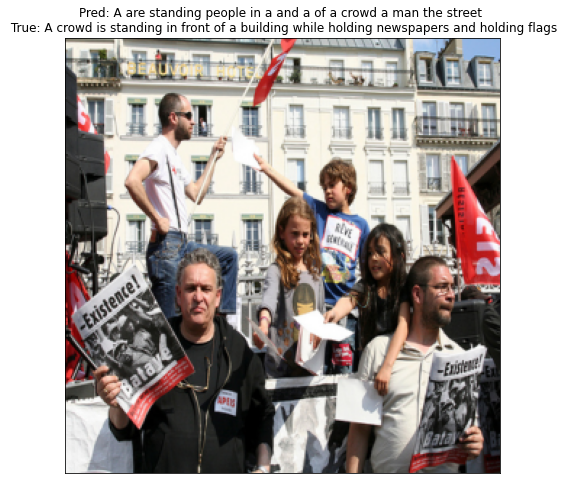

In [247]:
i = 0
show_pred(imgs[i], pred_labels[i], true_labels[i])

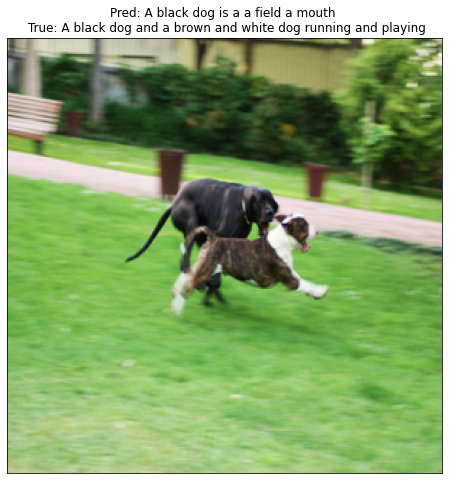

In [249]:
i = 15
show_pred(imgs[i], pred_labels[i], true_labels[i])